#Paralelizar código con **dask.delayed**

Dask tiene varias formas de ejecutar código en paralelo, para empezar vamos a utilizar **dask.distributed**

In [83]:
from dask.distributed import Client

##Básico

Primero se construyen dos funciones de prueba, la primera con inc y la segunda con add, que se van a mantener en principio inactivas. Y posteriormente, se programa la ejecución de las funciones con normalidad. 


In [84]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

In [85]:
%%time
# Esto toma tres segundos, porque se llama a a cada función secuencialmente una después de la otra
x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 126 ms, sys: 16.6 ms, total: 143 ms
Wall time: 3 s


#Paralelizando con dask.delayed

Las llamadas de incremento de x e y, se pueden llamar en paralelo, ya que son indenpendientes entre sí. 

Entonces, se transforma las funciones inc y add con la función dask.delayed. 


In [86]:
from dask import delayed

In [87]:
%%time

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: user 816 µs, sys: 0 ns, total: 816 µs
Wall time: 710 µs


Entonces, la operación se ejecuta inmediatamente, mucho más rápido que el código original. Y para obtener el resultado, que se llama al método `compute`.
Vemos que se obtuvo una reducción de casi un segundo en el tiempo de ejecución. 

In [88]:
%%time
z.compute()

CPU times: user 84.5 ms, sys: 11.4 ms, total: 95.9 ms
Wall time: 2 s


5

#¿Qué esta pasando?

A continuación, mostramos el gráfico que muestra como se estan realizado las operaciones para obtener el valor de $z$. 

In [89]:
z

Delayed('add-ac38cd6d-9b01-4158-aab0-d8f59d55e90c')

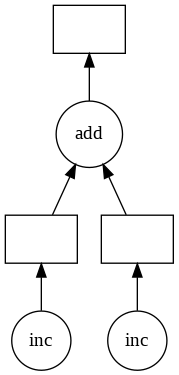

In [90]:
z.visualize()

##Ejercicio paralelizar un ciclo for

Generalmente necesitamos paralelizar los bucles for. Entonces con dask.delayed, lo podemos hacer como se muestra en este código. 

In [91]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [39]:
%%time
# Código secuencial 

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)
total

CPU times: user 445 ms, sys: 90.1 ms, total: 535 ms
Wall time: 8.01 s


In [92]:
total

90

In [93]:
%%time
#Código en paralelo 
for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)

#Primero se imprime, el objeto total antes de computarlo
print("Antes del computo", total)  
result = total.compute()
#Después del computo se obtiene
print("Después del computo :", result) 


Antes del computo Delayed('sum-c9c9c3c3-019b-4454-86c3-aa2b4140d793')
Después del computo : 134
CPU times: user 194 ms, sys: 14.9 ms, total: 208 ms
Wall time: 4.01 s


##Ejercicio paralelizar un bucle for con control de flujo

En ocasiones deseamos retrasar unas funciones determinadas, ejecutando algunas de estas inmediatamente. Entonces, debememos revisar que funciones retrasar y cuales no, y acá debemos validar con atención donde y cuando usar dask.layed. 

In [94]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [95]:
%%time
# Código secuencial

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)
    
total = sum(results)
print(total)

90
CPU times: user 482 ms, sys: 60 ms, total: 542 ms
Wall time: 10 s


In [96]:
%%time
#Código en paralelo 

results = []
for x in data:
    if is_even(x):  # even
        y = delayed(double)(x)
    else:          # odd
        y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)

CPU times: user 3.13 ms, sys: 0 ns, total: 3.13 ms
Wall time: 3.13 ms


In [45]:
%time total.compute()

CPU times: user 283 ms, sys: 40 ms, total: 323 ms
Wall time: 5.01 s


90

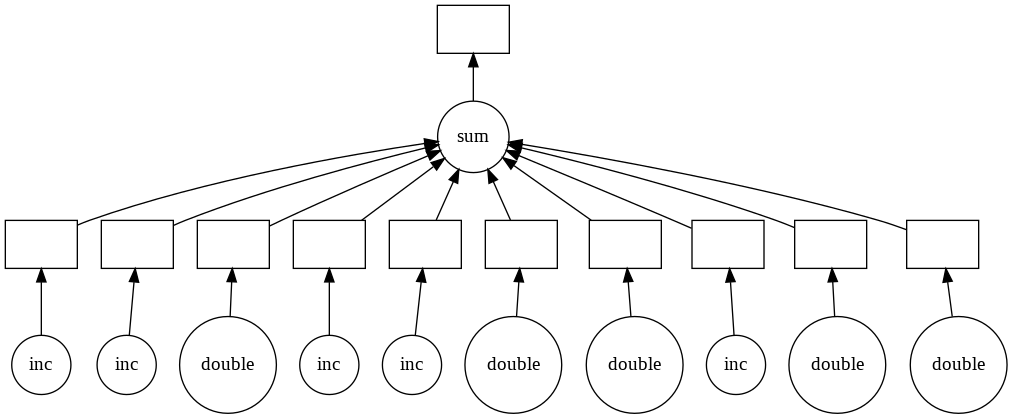

In [97]:
#A continuación, se presenta un gráfico en el que se muestra un gráfico en el que se visualiza como se esta realizando el computo. 
total.visualize()